In [1]:
import csv
import gzip
import os
import matplotlib
import scipy.io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import umap
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import Birch, AffinityPropagation, DBSCAN, MeanShift, SpectralClustering, AgglomerativeClustering, estimate_bandwidth
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import kneighbors_graph
from itertools import cycle, islice
import warnings
import scanpy as sc
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
matrix_dir = "genesrna"
mat = pd.read_csv("genesrna/rnamat.csv")
mat = np.array(mat)
features_path = os.path.join(matrix_dir, "features.txt")
annotation  = pd.read_csv(features_path,sep='\t',header=None)
annotation.columns = ['gene_names']
barcodes_path = os.path.join(matrix_dir, "barcodes.txt")
barcodes = [line.strip() for line in open(barcodes_path, 'r')]
mat = mat.T 
print('compiled!')
mat.shape

compiled!


(626, 22241)

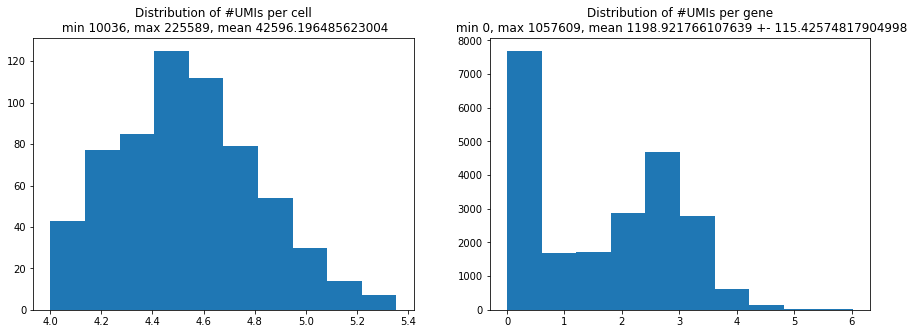

In [3]:
f, ax = plt.subplots(1, 2, figsize=(15, 5))
per_cell_sum = mat.sum(axis=1)
ax[0].hist(np.log10(per_cell_sum+1))
ax[0].set_title('Distribution of #UMIs per cell\n min {}, max {}, mean {}'.format(min(per_cell_sum), max(per_cell_sum), np.mean(per_cell_sum), np.sqrt(np.std(per_cell_sum))));

per_gene_sum = mat.sum(axis=0)
ax[1].hist(np.log10(per_gene_sum+1));
ax[1].set_title('Distribution of #UMIs per gene\n min {}, max {}, mean {} +- {}'.format(min(per_gene_sum), max(per_gene_sum), np.mean(per_gene_sum), np.sqrt(np.std(per_gene_sum))));
plt.show()

Text(0.5, 1.0, 'Distribution of CV, mean 1.4662495368124753 sd 1.0003227369510244')

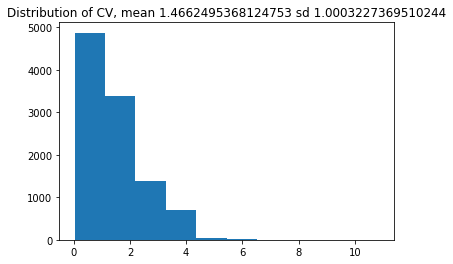

In [4]:
low_expr_thr = 100
high_expr_thr = 1000000
mat = mat[:, (per_gene_sum>=low_expr_thr) & (per_gene_sum<=high_expr_thr)]
mean_exp = mat.mean(axis=0)
std_exp = np.sqrt(mat.std(axis=0))
CV = std_exp/mean_exp
plt.hist(CV)
plt.title('Distribution of CV, mean {} sd {}'.format(np.mean(CV), np.std(CV)**0.5))

(626, 3951)


Text(0.5, 1.0, 'Distribution of #UMIs per gene\n min 100, max 2601, mean 257.64464692482915 +1 11.208466954917885')

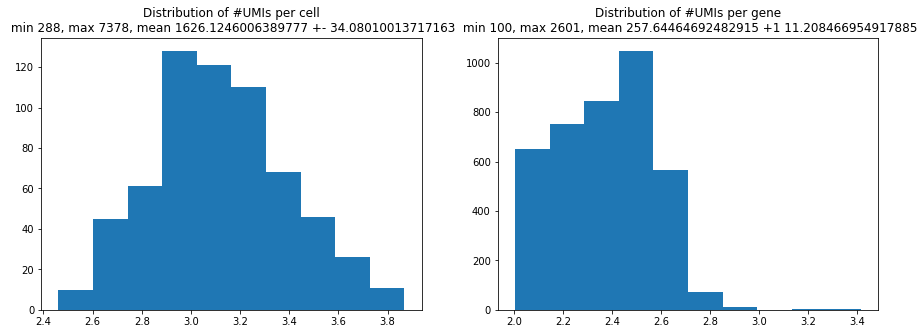

In [5]:
mat = mat[:, CV >= 1.5]
print(mat.shape)
f, ax = plt.subplots(1, 2, figsize=(15, 5))
per_cell_sum = mat.sum(axis = 1)
ax[0].hist(np.log10(per_cell_sum+1))
ax[0].set_title('Distribution of #UMIs per cell\n min {}, max {}, mean {} +- {}'.format(min(per_cell_sum), max(per_cell_sum), np.mean(per_cell_sum), np.sqrt(np.std(per_cell_sum))))

per_gene_sum = mat.sum(axis=0)
ax[1].hist(np.log10(per_gene_sum+1))
ax[1].set_title('Distribution of #UMIs per gene\n min {}, max {}, mean {} +1 {}'.format(min(per_gene_sum), max(per_gene_sum), np.mean(per_gene_sum), np.sqrt(np.std(per_gene_sum))))

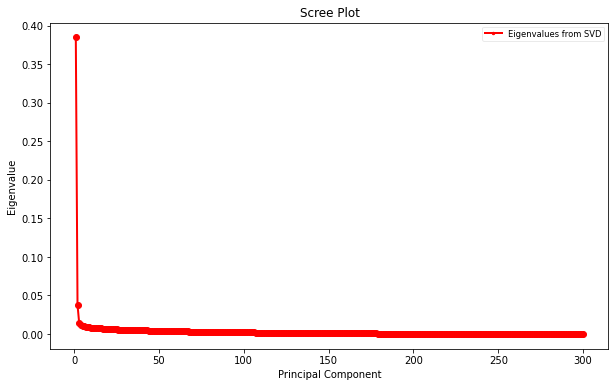

In [6]:
cells_expression = mat.sum(axis=1)
mat = mat[cells_expression>=100, :]
mat = np.log(mat+1)
test = mat[:300, :300]
U, S, V = np.linalg.svd(test) 
eigvals = S**2 / np.sum(S**2)  # NOTE (@amoeba): These are not PCA eigenvalues. 
                               # This question is about SVD.

fig = plt.figure(figsize=(10, 6))
sing_vals = np.arange(len(test)) + 1
plt.plot(sing_vals, eigvals, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
#I don't like the default legend so I typically make mine like below, e.g.
#with smaller fonts and a bit transparent so I do not cover up data, and make
#it moveable by the viewer in case upper-right is a bad place for it 
leg = plt.legend(['Eigenvalues from SVD'], loc='best', borderpad=0.3, 
                 shadow=False, prop=matplotlib.font_manager.FontProperties(size='small'),
                 markerscale=0.4)
leg.get_frame().set_alpha(0.4)
fig.savefig('Zoomed in Scree Plot.png')
#leg.draggable(state=True)

Text(0.5, 1.0, 'Naive Clustering')

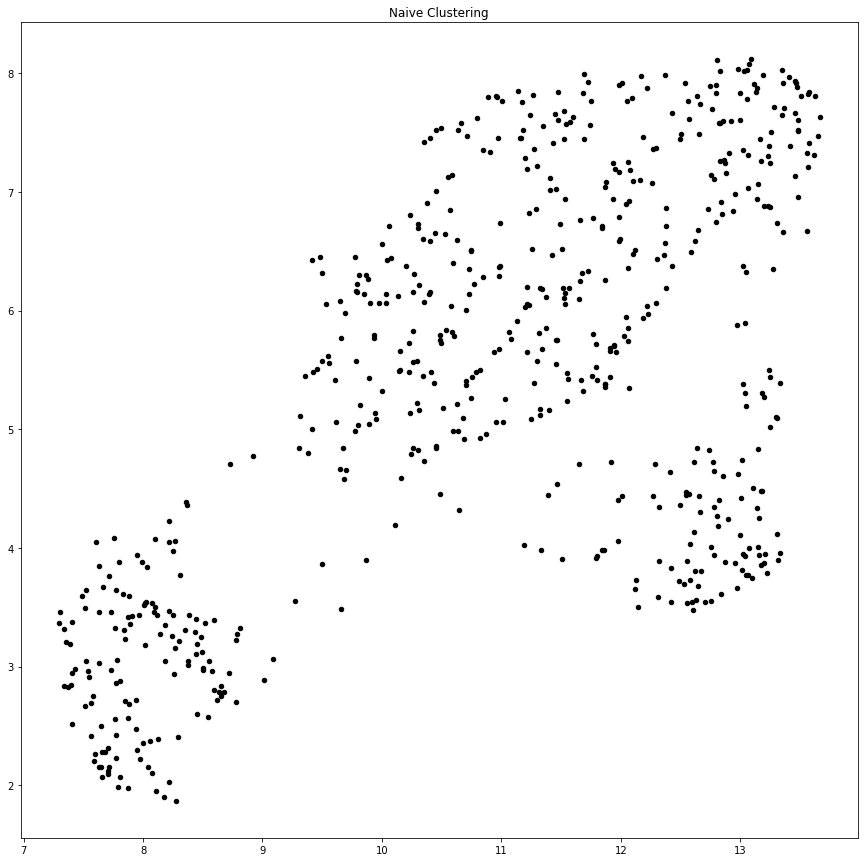

In [7]:
pca = PCA(n_components=50)
pca.fit(mat)
mat_reduce=pca.transform(mat)
embedding = umap.UMAP(n_neighbors=30, min_dist=0.01, metric='euclidean').fit_transform(mat_reduce)
plt.figure(figsize=(15, 15))
plt.scatter(embedding[:,0],embedding[:,1], s=20.0, color='black')
plt.title('Naive Clustering')

[3 3 3 1 1 3 3 0 3 3 0 3 1 3 1 3 3 0 1 3 3 0 1 0 3 0 0 1 1 1 0 1 0 0 1 0 3
 1 3 3 3 1 3 0 0 3 0 0 3 1 3 0 0 1 0 3 0 0 0 0 1 1 0 3 1 0 0 1 0 1 1 3 3 0
 3 3 3 0 1 0 1 1 1 0 0 0 0 0 1 0 1 3 1 3 3 0 1 3 1 0 0 3 3 0 0 1 1 3 3 3 3
 0 3 3 3 1 3 3 1 3 0 1 0 0 0 3 1 0 1 1 0 1 0 2 0 3 3 3 1 3 3 1 1 0 3 0 0 0
 1 0 3 0 3 3 3 3 1 3 3 3 3 3 3 0 0 3 1 0 3 3 1 1 0 0 3 3 1 1 0 1 3 3 3 3 3
 0 3 0 3 3 3 0 1 0 1 1 0 0 1 0 0 3 0 1 3 1 3 0 1 3 1 3 0 1 1 0 3 0 1 1 0 0
 0 1 3 3 1 3 1 1 3 0 3 1 1 0 3 0 1 3 0 1 1 1 3 0 1 1 3 3 3 1 3 0 0 3 0 0 0
 0 1 3 3 2 3 3 1 3 0 3 1 0 3 3 1 1 3 3 2 3 1 0 3 3 1 3 3 1 3 0 3 0 3 0 0 3
 3 3 3 2 3 1 3 2 1 1 3 1 0 3 3 1 3 3 3 3 1 1 3 3 1 1 0 3 0 1 3 3 2 0 0 2 0
 3 3 1 3 1 1 2 3 0 3 2 3 3 1 3 3 3 1 1 3 2 3 3 2 2 2 1 2 0 3 3 3 2 0 3 0 3
 0 3 3 0 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 1 1 2 1 2 2 2 2 0 2 1 0 0 2 2 1 2 2
 3 1 3 2 0 3 2 2 2 3 2 2 2 2 1 1 2 2 2 2 2 2 1 2 2 2 2 2 2 2 0 2 2 2 2 2 2
 2 2 0 2 2 2 0 2 1 1 0 3 0 1 2 0 3 1 1 1 0 1 0 0 1 0 0 2 2 1 0 1 0 2 3 0 0
 0 0 3 3 0 2 0 2 3 1 3 0 

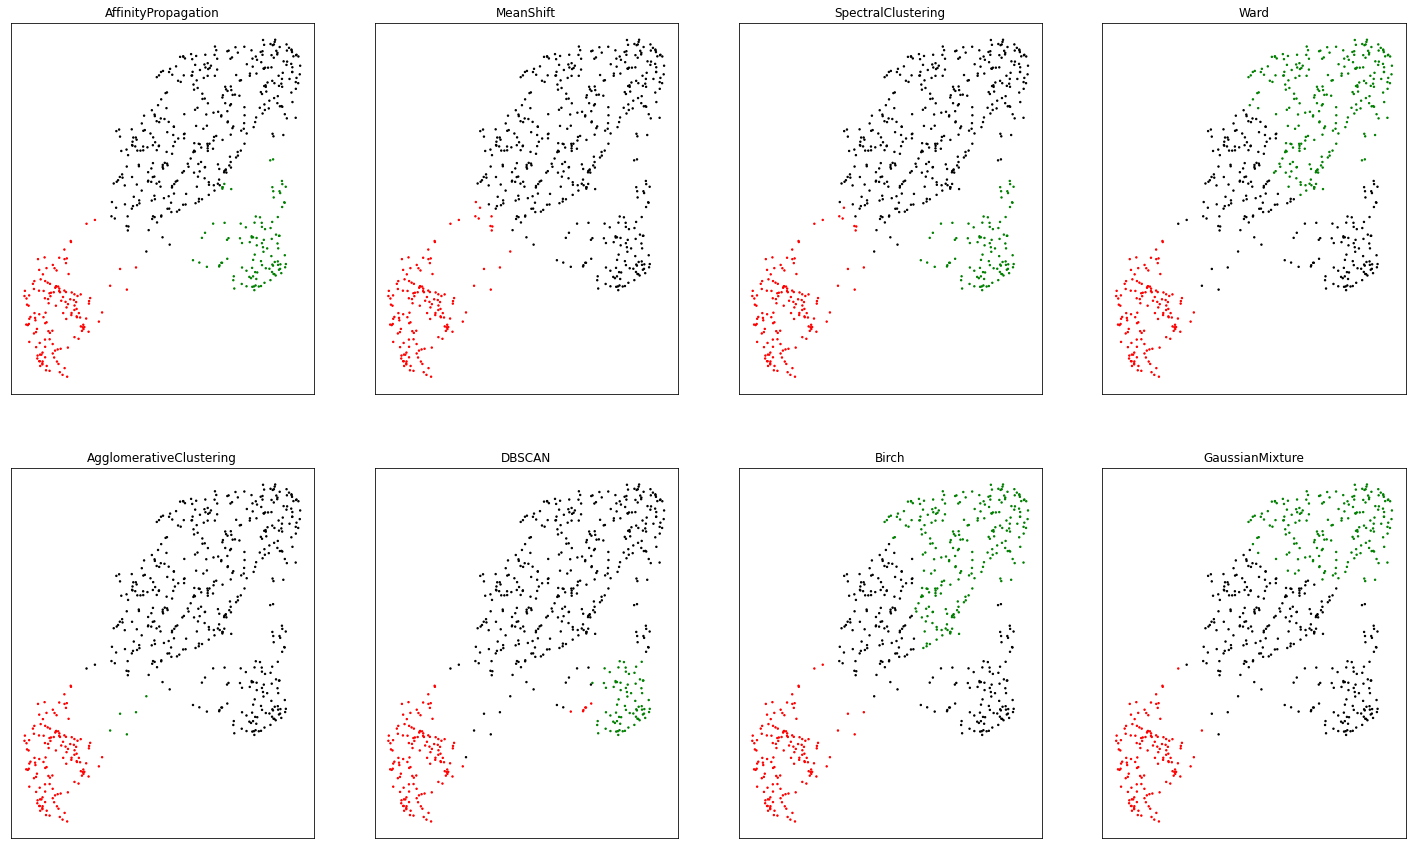

In [8]:
params = {'quantile': .3, 'eps': .3, 'damping': .9, 'preference':-200, 'n_neighbors':30, 'n_clusters':3}
bandwidth = estimate_bandwidth(embedding, quantile=params['quantile'])
connectivity = kneighbors_graph(embedding, n_neighbors=params['n_neighbors'], include_self = False)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ward = AgglomerativeClustering(n_clusters=params['n_clusters'], linkage='ward', connectivity=connectivity)
spectral = SpectralClustering(n_clusters=params['n_clusters'], eigen_solver='arpack', affinity="nearest_neighbors")
dbscan = DBSCAN(eps=params['eps'])
affinity_propagation = AffinityPropagation(damping=params['damping'], preference=params['preference'])
average_linkage = AgglomerativeClustering(linkage="average", affinity="cityblock", n_clusters=params['n_clusters'], connectivity=connectivity)
birch = Birch(n_clusters=params['n_clusters'])
gmm = GaussianMixture(n_components=params['n_clusters'], covariance_type='full')
clustering_algorithms = (
    ('AffinityPropagation', affinity_propagation),
    ('MeanShift', ms),
    ('SpectralClustering', spectral),
    ('Ward', ward),
    ('AgglomerativeClustering', average_linkage),
    ('DBSCAN', dbscan),
    ('Birch', birch),
    ('GaussianMixture', gmm))
#now plot everything
f, ax = plt.subplots(2, 4, figsize=(25,15))
for idx, (name, algorithm) in enumerate(clustering_algorithms):
    algorithm.fit(embedding)
    if hasattr(algorithm, 'labels_'):
        y_pred = algorithm.labels_.astype(np.int)
    else:
        y_pred = algorithm.predict(embedding)
    colors = np.array(list(islice(cycle(['black', 'red', 'green']),
                                    int(max(y_pred) + 1))))
        # add black color for outliers (if any)
    colors = np.append(colors, ["#000000"])
    ax[idx//4, idx%4].scatter(embedding[:, 0], embedding[:, 1], s=2, color=colors[y_pred])
    #ax[idx//4, idx%4].xlim(-2.5, 2.5)
    #ax[idx//4, idx%4].ylim(-2.5, 2.5)
    ax[idx//4, idx%4].set_xticks(())
    ax[idx//4, idx%4].set_yticks(())
    ax[idx//4, idx%4].set_title(name)
    #Store the labels
    if hasattr(algorithm, 'labels_'):
        labels = algorithm.labels_
    else:
        labels = algorithm.predict(embedding)
    
    #Then get the frequency count of the non-negative labels
    counts = np.bincount(labels[labels>=0])
    print(labels)
    print('{}'.format(name))
    print(counts)
plt.savefig('All Clusters.png')

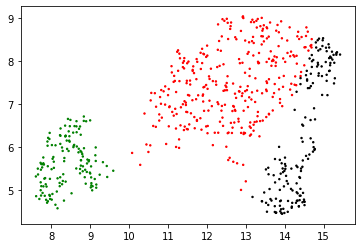

In [10]:
spectral.fit(embedding)
if hasattr(gmm, 'labels_'):
        y_pred = gmm.labels_.astype(np.int)
else:
        y_pred = gmm.predict(embedding)
colors = np.array(list(islice(cycle(['black', 'red', 'green']),int(max(y_pred) + 1))))
colors = np.append(colors, ["#000000"])
plt.scatter(embedding[:, 0], embedding[:, 1], s=2, color=colors[y_pred])